In [281]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


In [282]:
train=pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')

In [283]:
train.shape,test.shape 

((42000, 785), (28000, 784))

In [284]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [285]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [286]:
train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [287]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [288]:
Y_train=train['label']
X_train=train.drop(labels=['label'],axis=1)


In [289]:
X_train.shape,Y_train.shape

((42000, 784), (42000,))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

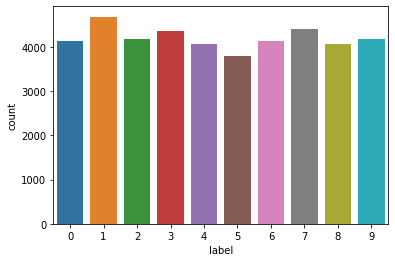

In [290]:
del train
g=sns.countplot(Y_train)
Y_train.value_counts()

In [291]:
#Normalization
X_train=X_train/255.0
X_test=test/255.0

In [292]:
#reshape the train and test images for the model into 28 by 28 images 
X_train=X_train.values.reshape(-1,28,28,1)
X_test=X_test.values.reshape(-1,28,28,1)

In [293]:
X_train.shape,X_test.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

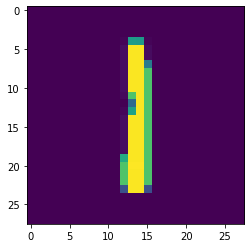

In [294]:
plt.imshow(X_train[2][:,:,0])

In [295]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='Same'),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='Same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='Same'),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='Same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10,activation='softmax')
    
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_45 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_47 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                 

In [296]:
Optimizer=tf.keras.optimizers.Adam(
learning_rate=0.005,
beta_1=0.9,
beta_2=0.999,
epsilon=1e-07,
name='Adam')

In [297]:
model.compile(optimizer=Optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [298]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [299]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [300]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [301]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


488/488 - 200s - loss: 2.3024 - accuracy: 0.1087 - val_loss: 2.3010 - val_accuracy: 0.1144 - lr: 0.0050 - 200s/epoch - 409ms/step


In [302]:
X_train.shape,Y_train.shape

((42000, 28, 28, 1), (42000,))

In [303]:
X_train.shape

(42000, 28, 28, 1)

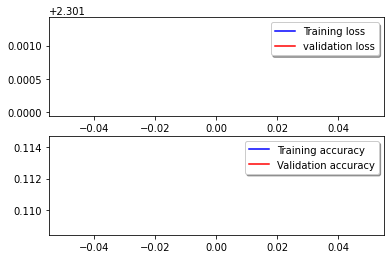

In [304]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


In [305]:

results = model.predict(X_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")


In [308]:
submission2=pd.concat([pd.Series(range(1,28001),name="ImageId"),results],axis=1)
submission2.to_csv("submission.csv",index=False)

In [309]:
submission2

,ImageId,Label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
27995,27996,1
27996,27997,1
27997,27998,1
27998,27999,1
